<div align="center">
  <h1 style="color:powderblue"><b>Streaming Intelligence: Real-time Machine Learning on Data Streams</b></h1>
</div>

*Directed by:*

- EL BOUGRINI Nassim
- HAFSI Siham
- CHAHIDI Khadija
- RAHMOUN Hayat
- NACHOUR Ilham
- AGOUMI Achraf

*Supervised by:*

- Thierry BERTIN

---


# Table of Contents

1. Project Overview:
  - Introduction
  - Objectives
  - Background Information
2. Main Steps:
  - Data Collection
  - Data Preprocessing
  - Feature Engineering
  - Model Building
    - Feature Selection
    - Modeling
  - Data Streaming
  - Automation
  - Testing and Validation
6. References and Citations:
7. Installation and Setup Instructions:

---

# Project Overview

## 1. Introduction:

The project, titled "*Real-time Machine Learning on Data Streams*", embodies the pursuit of harnessing the power of real-time data analysis and predictive modeling to address a crucial financial challenge - predicting the closing value of the IBM stock market.

In today's fast-paced financial landscape, making informed investment decisions requires access to the most current and relevant data. The project is driven by the mission to provide investors, traders, and financial analysts with a cutting-edge tool that leverages machine learning to predict the closing value of the IBM stock, thus facilitating better decision-making in the dynamic world of stock trading.


## 2. Objectives:

The primary objectives of this project include:

- Real-time Predictions: Develop a system capable of providing real-time predictions for the closing value of the IBM stock market, enabling users to stay ahead of market trends.

- Machine Learning Integration: Utilize advanced machine learning algorithms to analyze historical data, identify patterns, and generate accurate predictions.

- Data Stream Processing: Implement efficient data stream processing techniques to handle continuous and high-velocity data from the stock market.

- Performance Evaluation: Rigorously assess the accuracy and reliability of the prediction model through comprehensive performance evaluation.


## 3. Background Information:

In the age of big data and rapid technological advancements, financial markets are increasingly influenced by vast volumes of data generated in real-time. Accurately predicting stock prices, especially for a significant player like IBM, presents both a challenge and an opportunity.

This project builds upon previous work in real-time data analytics, machine learning, and financial forecasting. It seeks to apply and extend these concepts to the domain of stock market prediction, providing investors with an intelligent tool to make informed decisions.

As we delve into the main steps of this project, including data collection, analysis, and model building, we will explore the methodologies and techniques employed to achieve our objectives. The subsequent sections will provide detailed insights into each aspect of the project, aiming to deliver not only predictions but also a deeper understanding of the underlying dynamics of the IBM stock market.

# Import Librairies:

In [ ]:
# !pip install pmdarima
# !pip install confluent_kafka

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import math
import json
from google.colab import autoviz

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

import xgboost as xgb

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from confluent_kafka import Producer, Consumer

warnings.simplefilter(action='ignore')

# Data Collection:

In this section, we describe how data for the *IBM stock market* was collected using the **Alpha Vantage API**. This step is fundamental in obtaining the historical data necessary for our project's analysis and predictions.

In [5]:
# Define the Alpha Vantage API key and the stock symbol (in this case, "IBM")
API_KEY= "GFXPXW2YQLPO1TWI"
SYMBOL= "IBM"

In [6]:
# Construct the API request URL
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={SYMBOL}&outputsize=full&apikey={API_KEY}'

# Send a GET request to the API
r = requests.get(url)

# Parse the response as JSON
data = r.json()

# Explore the data structure
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

The `data` object returned from the API call is a dictionary with two main keys: `Meta Data` and `Time Series (Daily)`.

In [7]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'IBM',
 '3. Last Refreshed': '2023-09-01',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

`Meta Data` contains metadata about the data retrieved:

- `1. Information`: Describes the nature of the data, which includes daily prices (open, high, low, close) and volumes.
- `2. Symbol`: Specifies the stock symbol, in this case, 'IBM'.
- `3. Last Refreshed`: Indicates the date when the data was last updated.
- `4. Output Size`: States the output size, which is 'Full size' in this case.
- `5. Time Zone`: Specifies the time zone for the data, which is 'US/Eastern'.

In [8]:
print(data['Time Series (Daily)'])

{'2023-09-01': {'1. open': '147.2600', '2. high': '148.1000', '3. low': '146.9200', '4. close': '147.9400', '5. volume': '2727796'}, '2023-08-31': {'1. open': '146.9400', '2. high': '147.7275', '3. low': '146.5400', '4. close': '146.8300', '5. volume': '3885949'}, '2023-08-30': {'1. open': '146.4200', '2. high': '146.9200', '3. low': '145.7452', '4. close': '146.8600', '5. volume': '2245402'}, '2023-08-29': {'1. open': '146.3000', '2. high': '146.7300', '3. low': '145.6200', '4. close': '146.4500', '5. volume': '2778113'}, '2023-08-28': {'1. open': '145.4100', '2. high': '146.7400', '3. low': '145.2100', '4. close': '146.0200', '5. volume': '3561347'}, '2023-08-25': {'1. open': '144.1800', '2. high': '145.4700', '3. low': '143.5000', '4. close': '145.3500', '5. volume': '3660147'}, '2023-08-24': {'1. open': '143.5050', '2. high': '144.4700', '3. low': '143.2200', '4. close': '143.5500', '5. volume': '2900244'}, '2023-08-23': {'1. open': '141.7200', '2. high': '143.4750', '3. low': '141

The `Time Series (Daily)` data obtained from the *Alpha Vantage API* provides a detailed record of daily stock market information for the *IBM stock*. Below is an example of the structure of this data:

```json
{
  '2023-09-01': {
    '1. open': '147.2600',
    '2. high': '148.1000',
    '3. low': '146.9200',
    '4. close': '147.9400',
    '5. volume': '2727796'
  },
  ...
}
```

In a stock market context, "`open`", "`high`", "`low`", "`close`", and "`volume`" are terms used to describe different aspects of the price and trading activity of a particular stock or financial instrument on a given day.

1. **Open Price:**
   The "`open`" price is the price at which a stock or financial instrument started trading at the beginning of a trading session (e.g., a day). It is the first price at which buyers and sellers agreed to transact. The open price can be an important reference point for understanding the initial sentiment of traders at the start of the trading day.

2. **High Price:**
   The "`high`" price represents the highest price at which a stock traded during the trading session. It indicates the peak value the stock reached during the day. Traders often pay attention to the high price as it shows the upper limit of price movement within that session.

3. **Low Price:**
   The "`low`" price is the lowest price at which a stock traded during the trading session. It reflects the lowest value the stock reached during the day. Traders monitor the low price to understand the lower limit of price movement within that session.

4. **Closing Price:**
   The "`close`" price is the last price at which a stock traded before the trading session ended. It signifies the final transaction of the day. The closing price is often considered significant because it's used as a reference point for calculating gains or losses, and it's also the price used to determine the daily change in value.

5. **Volume:**
   The "`volume`" represents the total number of shares or contracts traded during the trading session. It quantifies the level of activity and interest in a particular stock. High volume can indicate strong market participation and interest, while low volume might suggest less interest or a lack of conviction among traders.

# Data Preprocessing:

In this section, we describe the preprocessing steps applied to the raw data obtained from the Alpha Vantage API to prepare it for analysis and modeling.

**Creating a DataFrame**: The raw data is initially stored as a dictionary. We create a Pandas DataFrame from the `Time Series (Daily)` data to facilitate data manipulation.

In [9]:
df = pd.DataFrame.from_dict(data['Time Series (Daily)']).T
df

,1. open,2. high,3. low,4. close,5. volume
2023-09-01,147.2600,148.1000,146.9200,147.9400,2727796
2023-08-31,146.9400,147.7275,146.5400,146.8300,3885949
2023-08-30,146.4200,146.9200,145.7452,146.8600,2245402
2023-08-29,146.3000,146.7300,145.6200,146.4500,2778113
2023-08-28,145.4100,146.7400,145.2100,146.0200,3561347
...,...,...,...,...,...
1999-11-05,92.7500,92.9400,90.1900,90.2500,13737600
1999-11-04,94.4400,94.4400,90.0000,91.5600,16697600
1999-11-03,95.8700,95.9400,93.5000,94.3700,10369100
1999-11-02,96.7500,96.8100,93.6900,94.8100,11105400


**Reordering the DataFrame**: To ensure that the data is in chronological order, we reverse the order of rows in the DataFrame.

In [10]:
df = df.reindex(index=df.index[::-1])
df

,1. open,2. high,3. low,4. close,5. volume
1999-11-01,98.5000,98.8100,96.3700,96.7500,9551800
1999-11-02,96.7500,96.8100,93.6900,94.8100,11105400
1999-11-03,95.8700,95.9400,93.5000,94.3700,10369100
1999-11-04,94.4400,94.4400,90.0000,91.5600,16697600
1999-11-05,92.7500,92.9400,90.1900,90.2500,13737600
...,...,...,...,...,...
2023-08-28,145.4100,146.7400,145.2100,146.0200,3561347
2023-08-29,146.3000,146.7300,145.6200,146.4500,2778113
2023-08-30,146.4200,146.9200,145.7452,146.8600,2245402
2023-08-31,146.9400,147.7275,146.5400,146.8300,3885949


**Column Label Cleanup**: We clean the column labels by removing the numeric prefixes ('1. open', '2. high', etc.) for improved readability.

In [11]:
df.columns = [col.split('. ')[1] for col in df.columns]
df.reset_index(inplace=True)
df.rename(columns={'index':'date'}, inplace=True)
df

,date,open,high,low,close,volume
0,1999-11-01,98.5000,98.8100,96.3700,96.7500,9551800
1,1999-11-02,96.7500,96.8100,93.6900,94.8100,11105400
2,1999-11-03,95.8700,95.9400,93.5000,94.3700,10369100
3,1999-11-04,94.4400,94.4400,90.0000,91.5600,16697600
4,1999-11-05,92.7500,92.9400,90.1900,90.2500,13737600
...,...,...,...,...,...,...
5993,2023-08-28,145.4100,146.7400,145.2100,146.0200,3561347
5994,2023-08-29,146.3000,146.7300,145.6200,146.4500,2778113
5995,2023-08-30,146.4200,146.9200,145.7452,146.8600,2245402
5996,2023-08-31,146.9400,147.7275,146.5400,146.8300,3885949


In [12]:
df.dtypes

date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object

**Data Type Conversion**: The numeric columns ('open', 'high', 'low', 'close', 'volume') are converted to the appropriate numeric data types, and the 'date' column to the datetime data type to facilitate date-based analysis.

In [13]:
df['date'] = pd.to_datetime(df['date'])
df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])
df['volume'] = pd.to_numeric(df['volume'])

**Handling Missing Values**: We check for missing values in the DataFrame and confirm that there are no missing data points.

In [14]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

**Data Summary**: Finally, we provide a summary of the preprocessed data using `df.describe()`, which includes statistical information about the numeric columns.

In [15]:
df.describe()

,open,high,low,close,volume
count,5998.000000,5998.000000,5998.000000,5998.000000,5.998000e+03
mean,129.541624,130.719221,128.443293,129.598778,5.981138e+06
std,35.454521,35.508370,35.407183,35.464185,3.316944e+06
min,54.650000,56.700000,54.010000,55.070000,1.928430e+05
25%,99.150000,100.067500,98.280000,99.317500,3.804086e+06
50%,127.230000,128.290000,126.250000,127.300000,5.150568e+06
75%,152.547500,153.657500,151.645000,152.520000,7.186775e+06
max,215.380000,215.900000,214.300000,215.800000,4.120730e+07


# Visualizations:

In [16]:
display(df)

,date,open,high,low,close,volume
0,1999-11-01,98.50,98.8100,96.3700,96.75,9551800
1,1999-11-02,96.75,96.8100,93.6900,94.81,11105400
2,1999-11-03,95.87,95.9400,93.5000,94.37,10369100
3,1999-11-04,94.44,94.4400,90.0000,91.56,16697600
4,1999-11-05,92.75,92.9400,90.1900,90.25,13737600
...,...,...,...,...,...,...
5993,2023-08-28,145.41,146.7400,145.2100,146.02,3561347
5994,2023-08-29,146.30,146.7300,145.6200,146.45,2778113
5995,2023-08-30,146.42,146.9200,145.7452,146.86,2245402
5996,2023-08-31,146.94,147.7275,146.5400,146.83,3885949


**Plot of Values:**

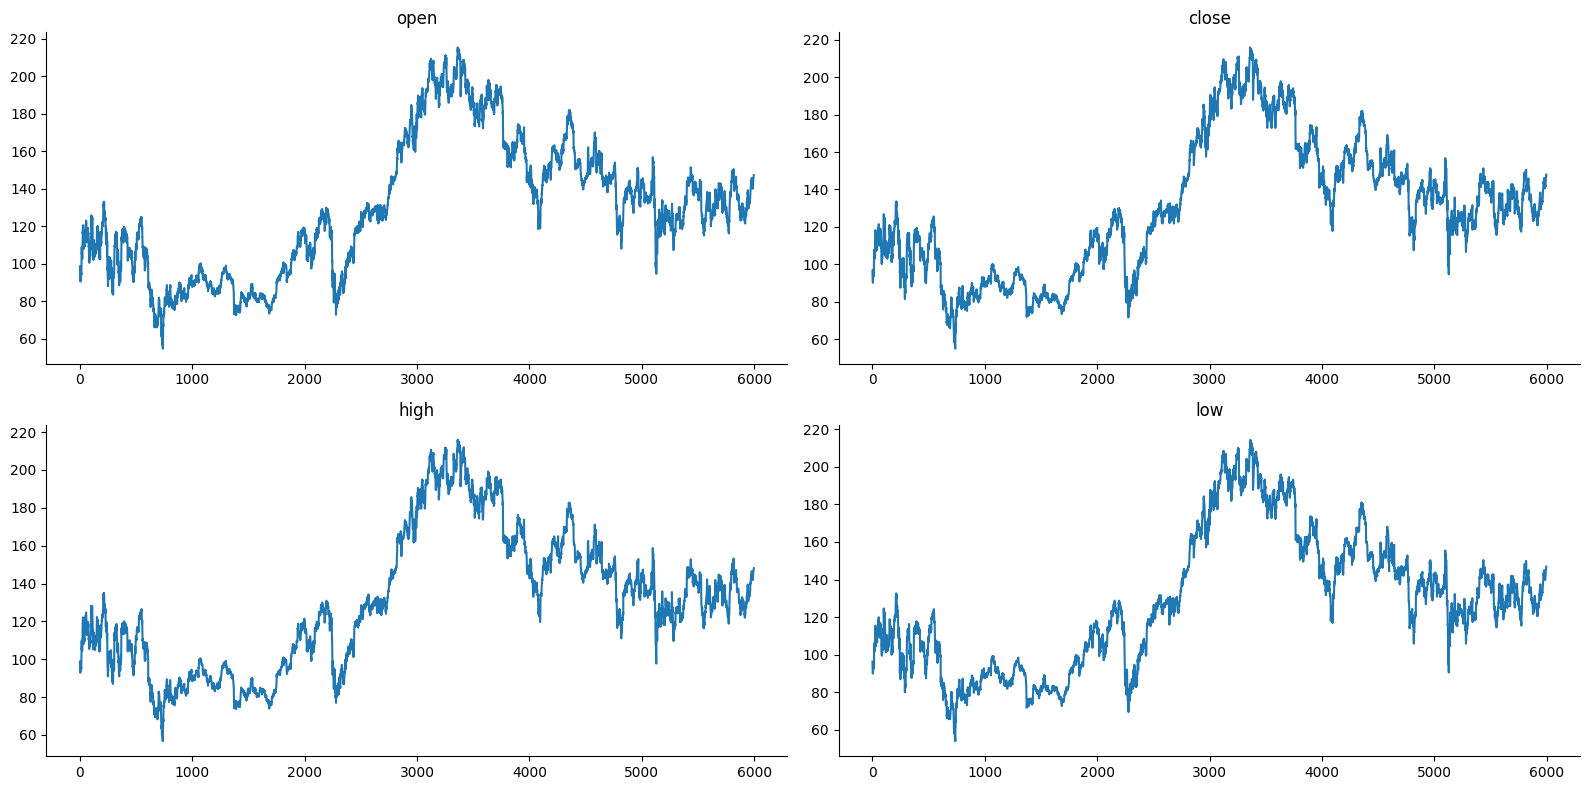

In [17]:
def value_plot(df, y, ax):
    df[y].plot(kind='line', ax=ax, title=y)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

for i, c in enumerate(['open', 'close', 'high', 'low']):
    row = i // 2
    col = i % 2
    value_plot(df, c, ax=axes[row, col])

plt.tight_layout()
plt.show()

**Plot of Distributions:**

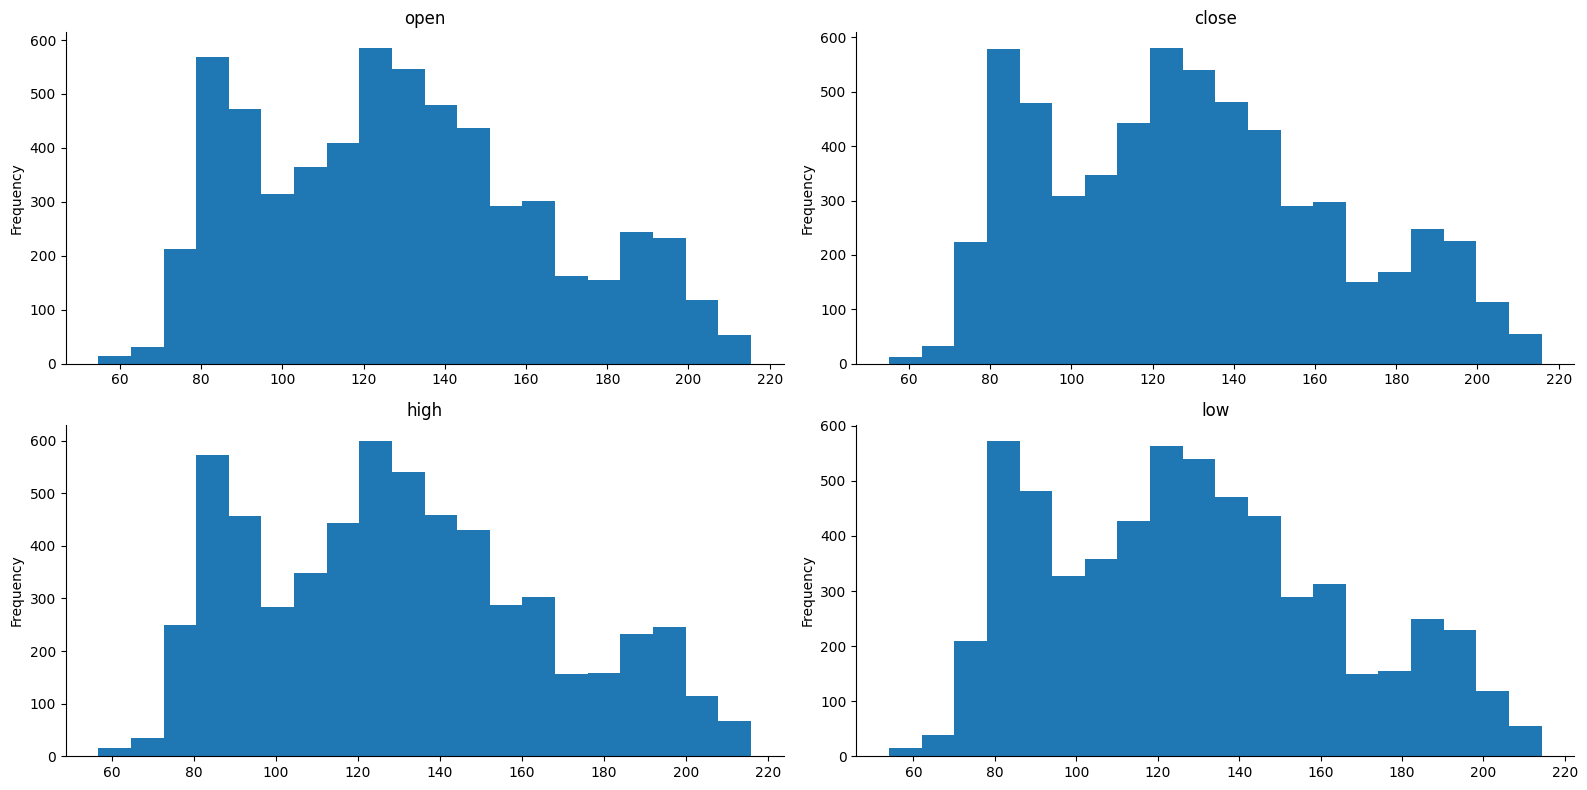

In [18]:
def histogram(df, colname, num_bins=20, ax=None):
    if ax is None:
        ax = plt.gca()
    df[colname].plot(kind='hist', bins=num_bins, ax=ax, title=colname)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

for i, c in enumerate(['open', 'close', 'high', 'low']):
    row = i // 2
    col = i % 2
    histogram(df, c, ax=axes[row, col])

plt.tight_layout()
plt.show()

**Time Series:**

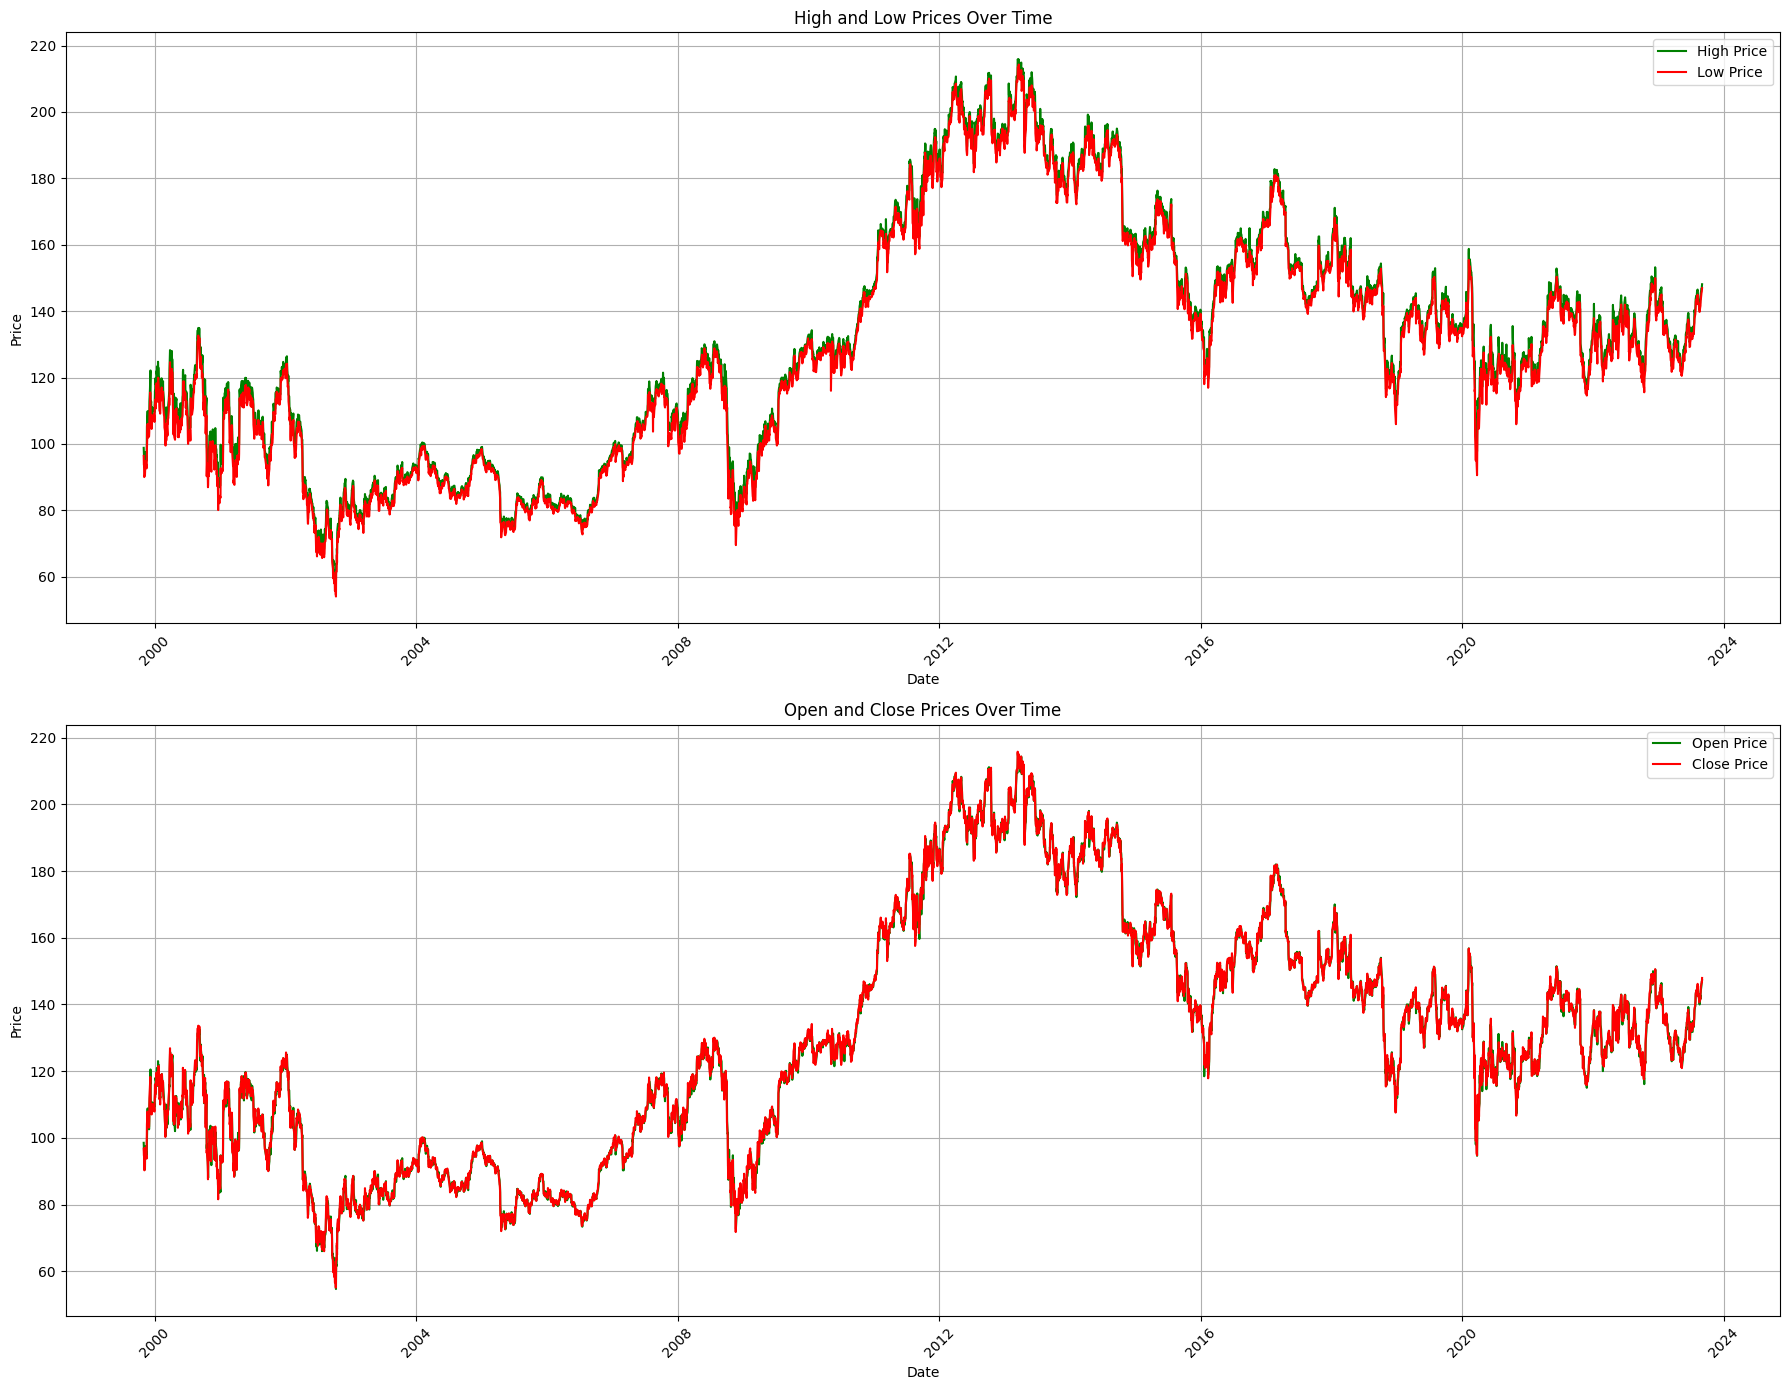

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 14))

# First Subplot: High and Low Prices
axes[0].plot(df['date'], df['high'], label='High Price', color='green')
axes[0].plot(df['date'], df['low'], label='Low Price', color='red')
axes[0].set_title('High and Low Prices Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Second Subplot: Open and Close Prices
axes[1].plot(df['date'], df['open'], label='Open Price', color='green')
axes[1].plot(df['date'], df['close'], label='Close Price', color='red')
axes[1].set_title('Open and Close Prices Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering:

In this section, we perform feature engineering on our dataset to create relevant features and prepare it for machine learning modeling.

In [20]:
df_orig = df.copy()

__Lagged Features (Past 3 Days):__

These features capture the historical behavior of prices and volumes over the past three days. They can be used to model how recent price changes relate to previous days' prices, potentially capturing short-term trends and momentum.

In [21]:
for lag in range(1, 4):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

__Technical Indicators (Moving Averages, RSI):__

Technical indicators provide insights into market trends and overbought/oversold conditions. You might use these indicators as signals for entering or exiting trades. For example:

* `Moving Averages`: Crossovers between short-term and long-term moving averages can be used as trend-change indicators.
* `RSI`: Extreme values (over 70 or under 30) might indicate potential reversal points.

In [22]:
def calculate_rsi(close_prices, window=14):
    diff = close_prices.diff()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['sma_14'] = df['close'].rolling(window=14).mean()
df['rsi'] = calculate_rsi(df['close'], window=14)

__Percentage Change:__

We calculate the percentage change in the closing price and trading volume, providing insights into daily price movement and trading activity.

In [23]:
df['close_pct_change'] = df['close'].pct_change()  # Percentage change in closing price
df['volume_change'] = df['volume'].pct_change()  # Percentage change in volume

__Adding Date-related Features:__

We can extract additional date-related information from the `date` column, such as day of the *week*, *month*, and *year*, which can provide valuable insights. Certain days or months might exhibit different patterns.

In [24]:
df['day_of_week'] = df['date'].dt.dayofweek  # Monday: 0, Sunday: 6
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

__Price Ratios:__

Price ratios offer insights into price relationships. For example:
* `High-Low Ratio`: A high ratio might indicate increased volatility, while a low ratio might suggest stable price movements.
* `Close-Open Ratio`: A ratio greater than 1 might indicate bullishness (close > open), while a ratio less than 1 might suggest bearishness.

In [25]:
df['high_low_ratio'] = df['high'] / df['low']
df['close_open_ratio'] = df['close'] / df['open']

So, the new DataFrame would look like this:

In [26]:
pd.set_option('display.max_columns', None)
display(df)
pd.reset_option('ax_columns')

,date,open,high,low,close,volume,open_lag_1,high_lag_1,low_lag_1,close_lag_1,volume_lag_1,open_lag_2,high_lag_2,low_lag_2,close_lag_2,volume_lag_2,open_lag_3,high_lag_3,low_lag_3,close_lag_3,volume_lag_3,sma_14,rsi,close_pct_change,volume_change,day_of_week,month,year,high_low_ratio,close_open_ratio
0,1999-11-01,98.50,98.8100,96.3700,96.75,9551800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11,1999,1.025319,0.982234
1,1999-11-02,96.75,96.8100,93.6900,94.81,11105400,98.50,98.8100,96.3700,96.75,9551800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.020052,0.162650,1,11,1999,1.033301,0.979948
2,1999-11-03,95.87,95.9400,93.5000,94.37,10369100,96.75,96.8100,93.6900,94.81,11105400.0,98.500,98.81,96.3700,96.75,9551800.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.004641,-0.066301,2,11,1999,1.026096,0.984354
3,1999-11-04,94.44,94.4400,90.0000,91.56,16697600,95.87,95.9400,93.5000,94.37,10369100.0,96.750,96.81,93.6900,94.81,11105400.0,98.500,98.810,96.37,96.75,9551800.0,NaN,0.000000,-0.029776,0.610323,3,11,1999,1.049333,0.969504
4,1999-11-05,92.75,92.9400,90.1900,90.25,13737600,94.44,94.4400,90.0000,91.56,16697600.0,95.870,95.94,93.5000,94.37,10369100.0,96.750,96.810,93.69,94.81,11105400.0,NaN,0.000000,-0.014308,-0.177271,4,11,1999,1.030491,0.973046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,2023-08-28,145.41,146.7400,145.2100,146.02,3561347,144.18,145.4700,143.5000,145.35,3660147.0,143.505,144.47,143.2200,143.55,2900244.0,141.720,143.475,141.58,143.41,2559083.0,142.675000,50.400000,0.004610,-0.026993,0,8,2023,1.010536,1.004195
5994,2023-08-29,146.30,146.7300,145.6200,146.45,2778113,145.41,146.7400,145.2100,146.02,3561347.0,144.180,145.47,143.5000,145.35,3660147.0,143.505,144.470,143.22,143.55,2900244.0,142.957857,68.401487,0.002945,-0.219926,1,8,2023,1.007623,1.001025
5995,2023-08-30,146.42,146.9200,145.7452,146.86,2245402,146.30,146.7300,145.6200,146.45,2778113.0,145.410,146.74,145.2100,146.02,3561347.0,144.180,145.470,143.50,145.35,3660147.0,143.215714,67.339097,0.002800,-0.191753,2,8,2023,1.008061,1.003005
5996,2023-08-31,146.94,147.7275,146.5400,146.83,3885949,146.42,146.9200,145.7452,146.86,2245402.0,146.300,146.73,145.6200,146.45,2778113.0,145.410,146.740,145.21,146.02,3561347.0,143.480714,67.992241,-0.000204,0.730625,3,8,2023,1.008104,0.999251


# Model Building

In this section, we outline the process of building, training, and evaluating predictive models for stock price prediction. We explore three different models: `ARIMA`, `Random Forest`, and `XGBoost`.

## Random Forest Model:

### Features Selection:

In [27]:
df_rf = df.copy()
display(df_rf.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'open_lag_1',
       'high_lag_1', 'low_lag_1', 'close_lag_1', 'volume_lag_1', 'open_lag_2',
       'high_lag_2', 'low_lag_2', 'close_lag_2', 'volume_lag_2', 'open_lag_3',
       'high_lag_3', 'low_lag_3', 'close_lag_3', 'volume_lag_3', 'sma_14',
       'rsi', 'close_pct_change', 'volume_change', 'day_of_week', 'month',
       'year', 'high_low_ratio', 'close_open_ratio'],
      dtype='object')

**Null values:**

In [28]:
nulls = pd.DataFrame(df_rf.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls = nulls[nulls['Null Count']!=0]
nulls

,Null Count
Feature,
sma_14,13
volume_lag_3,3
close_lag_3,3
low_lag_3,3
high_lag_3,3
open_lag_3,3
volume_lag_2,2
high_lag_2,2
close_lag_2,2


In [29]:
df_rf.dropna(axis=0, inplace=True)

print(f"Number of null values: {df_rf.isnull().sum().sum()}")

Number of null values: 0


__Correlation Analysis:__

In [30]:
correlation_matrix = df_rf.corr()
correlation_with_target = correlation_matrix['close'].abs()\
          .sort_values(ascending=False).to_frame()\
          .style.format({'SalePrice': '{:.03f}'}).background_gradient('Blues')

correlation_with_target

,close
close,1.000000
high,0.999544
low,0.999535
open,0.999068
close_lag_1,0.998443
low_lag_1,0.998082
high_lag_1,0.998074
open_lag_1,0.997600
close_lag_2,0.996959
low_lag_2,0.996626


__Feature Importance:__

In [31]:
X = df_rf.drop(['date', 'close'], axis=1)
y = df_rf['close']

model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [32]:
feature_importances = model.feature_importances_
sorted_feature_importances = sorted(zip(X.columns, feature_importances),
                                    key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: low, Importance: 0.6122199116290954
Feature: high, Importance: 0.38483579091404607
Feature: open, Importance: 0.0024836553426697797
Feature: close_open_ratio, Importance: 0.00022655327245511635
Feature: close_pct_change, Importance: 7.371598796875086e-05
Feature: high_low_ratio, Importance: 1.9459720290517563e-05
Feature: rsi, Importance: 1.0650050234890486e-05
Feature: low_lag_1, Importance: 1.0388085125781838e-05
Feature: close_lag_1, Importance: 9.953499447872833e-06
Feature: volume_lag_2, Importance: 8.692937952999185e-06
Feature: volume, Importance: 8.159085778793398e-06
Feature: high_lag_1, Importance: 7.76189510227524e-06
Feature: volume_lag_1, Importance: 7.736475547585888e-06
Feature: volume_lag_3, Importance: 7.428374075565849e-06
Feature: sma_14, Importance: 7.20208448979739e-06
Feature: volume_change, Importance: 7.1412961473962685e-06
Feature: month, Importance: 5.972842802069663e-06
Feature: low_lag_3, Importance: 5.797225739557755e-06
Feature: open_lag_3, Import

__Recursive Feature Elimination (RFE):__

In [33]:
X = df_rf.drop(['date', 'close'], axis=1)
y = df_rf['close']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)

rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['open', 'high', 'low', 'high_lag_3', 'low_lag_3', 'close_pct_change',
       'high_low_ratio', 'close_open_ratio'],
      dtype='object')


__Interpret Results:__

1. _Correlation Analysis:_

  * Features with high absolute correlation (close to 1) with the target variable ("close") are the ones that are most linearly related to the target. In our case, "`high`", "`low`", "`open`", `SMA`, and `lagged prices` show extremely high correlations.
  * High correlation values can indicate strong `multicollinearity`, which means that these features may contain redundant information.

2. _Feature Importance:_

  * Feature importance indicates the contribution of each feature in predicting the target. Features like "`low`" and "`high`" have higher importances, suggesting that they play a significant role in predicting the next day's close price.
  * Features with lower importances ("`close_open_ratio`", "`close_pct_change`", etc.) might have limited predictive power.

3. _RFE_:

  * RFE selected a subset of features that the model considers most important for predicting the target. The selected features include both price-related features ("`open`", "`high`", "`low`") and lagged features ("`high_lag_3`", "`low_lag_3`").
  * The inclusion of "`close_pct_change`", "`high_low_ratio`", and "`close_open_ratio`" suggests that these features might provide meaningful information.

> To mitigate the effects of multicollinearity, it is advisable to contemplate the removal of one of the correlated features. Furthermore, sophisticated techniques like Ridge or Lasso regression offer solutions to multicollinearity by automatically tempering the influence of correlated features during model training.

To mitigate multicollinearity, we'll remove the `open` feature, it has a high correlation and a low importance:

In [34]:
df_rf = df_rf.drop(['open'], axis=1)

Now, we'll repeat the process:

In [35]:
print("Correlation:")
correlation_matrix = df_rf.corr()
correlation_with_target = correlation_matrix['close'].abs()\
        .sort_values(ascending=False).to_frame()\
        .style.format({'SalePrice': '{:.03f}'}).background_gradient('Blues')

display(correlation_with_target)

Correlation:


,close
close,1.000000
high,0.999544
low,0.999535
close_lag_1,0.998443
low_lag_1,0.998082
high_lag_1,0.998074
open_lag_1,0.997600
close_lag_2,0.996959
low_lag_2,0.996626
high_lag_2,0.996600


In [36]:
print("Feature Importance:\n")

X = df_rf.drop(['date', 'close'], axis=1)
y = df_rf['close']

model = RandomForestRegressor()
model.fit(X, y)

feature_importances = model.feature_importances_
sorted_feature_importances = sorted(zip(X.columns, feature_importances),
                                    key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature Importance:
Feature: low, Importance: 0.6286260796608925
Feature: high, Importance: 0.3708987475555381
Feature: close_open_ratio, Importance: 0.00021964150071934524
Feature: close_pct_change, Importance: 7.839508193385508e-05
Feature: high_low_ratio, Importance: 2.0978842844508228e-05
Feature: high_lag_1, Importance: 1.3125439570993791e-05
Feature: close_lag_1, Importance: 1.2179566996888962e-05
Feature: rsi, Importance: 1.020784446014554e-05
Feature: volume_lag_1, Importance: 9.115449646517489e-06
Feature: low_lag_1, Importance: 8.796165238787676e-06
Feature: sma_14, Importance: 8.558287507997914e-06
Feature: volume, Importance: 8.293790289605169e-06
Feature: volume_lag_2, Importance: 8.212165108154784e-06
Feature: volume_lag_3, Importance: 8.106214672668388e-06
Feature: volume_change, Importance: 7.542012517375693e-06
Feature: month, Importance: 6.866312033046468e-06
Feature: open_lag_1, Importance: 6.390784858690153e-06
Feature: high_lag_2, Importance: 5.983915603288209e-06


In [37]:
print("RFE:\n")

X = df_rf.drop(['date', 'close'], axis=1)
y = df_rf['close']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)

rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

RFE:
Selected Features: Index(['high', 'low', 'close_lag_1', 'high_lag_3', 'low_lag_3',
       'close_pct_change', 'high_low_ratio', 'close_open_ratio'],
      dtype='object')


__Interpret Results:__

* The updated analysis of importance and RFE outcomes indicate that the "`high`" and "`low`" features stand out as the most influential indicators. Moreover, certain `lagged features`, "`close_pct_change`", "`high_low_ratio`", and "`close_open_ratio`" are being selected as well. This suggests that these features may provide meaningful predictive power.

* To proceed, we can start by using the subset of features identified by the feature importance and RFE approaches. This subset encapsulates attributes that the model identifies as pivotal in forecasting the subsequent day's closing price. Subsequently, we propose constructing a model using these selected features in conjunction with `Ridge` or `Lasso` regression. This step will provide insight into how the regularization techniques influence model performance and enhance the stability of coefficient estimates.

__Conclusion:__

- _Target Variable:_

  The primary objective is to forecast the closing price for the upcoming trading day based on historical data and engineered features. The target variable for prediction is the "`close`" column, representing the next day's closing price.

- _Predictor Variables:_

  The essential predictor variables include "`low`", "`high`", "`close_lag_1`", "`low_lag_3`", "`high_lag_3`", "`close_pct_change`", "`high_low_ratio`", and "`close_open_ratio`".

### Modeling:

**Select the desired features for X:**

In [38]:
X = df_rf[['low', 'high', 'low_lag_3',
           'high_lag_3', 'close_lag_1',
           'close_pct_change', 'high_low_ratio',
           'close_open_ratio']]

**Define the target variable (y):**

In [39]:
y = df_rf['close']

**Split the data into training and testing sets:**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Create and fit the XGBoost model:**

In [41]:
model = RandomForestRegressor(n_estimators=100, max_depth=20,
                 min_samples_split=10, min_samples_leaf=1, random_state=1)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=1)

**Make predictions:**

In [42]:
y_pred = model.predict(X_test)

**Report performance metrics:**

In [43]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(y_pred - y_test) / np.abs(y_test))
r2 = r2_score(y_test, y_pred)

print("MSE: {:.3f}".format(mse))
print("MAE: {:.3f}".format(mae))
print("RMSE: {:.3f}".format(rmse))
print("MAPE: {:.3f}%".format(mape * 100))
print("R-squared: {}".format(r2))

MSE: 0.365
MAE: 0.404
RMSE: 0.604
MAPE: 0.336%
R-squared: 0.9997198647296429


## XGBoost Model:

### Feature Selection:

In [44]:
df_xgb = df.copy()

**correlation analysis:**

In [45]:
correlation_matrix = df_xgb.corr()

# Calculate the absolute correlation with the target variable and sort the values in descending order
correlation_with_target = correlation_matrix["close"].abs()\
        .sort_values(ascending=False).to_frame()\
        .style.background_gradient('Blues')

# Display the styled correlation DataFrame.
correlation_with_target

,close
close,1.000000
high,0.999544
low,0.999535
open,0.999066
close_lag_1,0.998443
low_lag_1,0.998083
high_lag_1,0.998075
open_lag_1,0.997599
close_lag_2,0.996960
low_lag_2,0.996626


**Feature importance:**

In [46]:
# Define the features (X) and target variable (y)
X=df_xgb.drop(columns=['date','close'])
y=df_xgb['close']

In [47]:
# Create an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.5,
    objective='reg:squarederror',
    random_state=42
)

# Fit the model to the data
xgb_model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [48]:
# Calculate feature importance scores
feature_importance = xgb_model.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importance)}
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance scores
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

low: 0.656703770160675
high: 0.3416835069656372
close_open_ratio: 0.00040332856588065624
open: 0.0003058596921619028
close_pct_change: 0.00010809561354108155
high_lag_1: 9.856123506324366e-05
sma_14: 8.583627641201019e-05
close_lag_1: 6.131518603069708e-05
open_lag_3: 5.545506064663641e-05
high_low_ratio: 4.360941966297105e-05
low_lag_1: 3.88700318580959e-05
year: 3.8676836993545294e-05
high_lag_3: 3.8191574276424944e-05
close_lag_2: 3.2366602681577206e-05
high_lag_2: 3.0154547857819125e-05
volume_change: 2.6208570488961414e-05
month: 2.4848352040862665e-05
close_lag_3: 2.452005173836369e-05
open_lag_2: 2.4368759113713168e-05
volume: 2.147134546248708e-05
rsi: 2.105098610627465e-05
volume_lag_2: 2.0994271835661493e-05
low_lag_3: 2.0941030015819706e-05
low_lag_2: 2.093891816912219e-05
day_of_week: 1.828513813961763e-05
volume_lag_3: 1.8102557078236714e-05
open_lag_1: 1.6412906916229986e-05
volume_lag_1: 1.4340374036692083e-05


__Interpret Results:__

1. _Correlation Analysis:_

  * Features with high absolute correlation (close to 1) with the target variable ("close") are the ones that are most linearly related to the target. In our case, "`high`", "`low`", "`open`", `SMA`, and `lagged prices` show extremely high correlations.

2. _Feature Importance:_

  * Feature importance indicates the contribution of each feature in predicting the target. Features like "`open`" and "`high`" have higher importances, suggesting that they play a significant role in predicting the next day's close price.
  * Features with lower importances ("`volume_change`", "`month`", etc.) might have limited predictive power.

__Conclusion:__

- _Target Variable:_

  The primary objective is to forecast the closing price for the upcoming trading day based on historical data and engineered features. The target variable for prediction is the "`close`" column, representing the next day's closing price.

- _Predictor Variables:_

  The essential predictor variables include "`low`", "`high`", `open`, "`open_lag_1`", "`low_lag_1`", "`sma_14`", "`close_open_ratio`", "`high_lag_1`", and "`close_pct_change`".

### Modeling:

**Select the desired features for X:**

In [49]:
X=df_xgb[['low','high','open_lag_1',
      'low_lag_1','sma_14','close_open_ratio',
      'open','high_lag_1','close_pct_change']]

**Define the target variable (y):**

In [50]:
y=df_xgb['close']

**Split the data into training and testing sets:**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Create and fit the XGBoost model:**

In [52]:
xgb_model = xgb.XGBRegressor(n_estimators=500,
                             max_depth=3,
                             learning_rate=0.5,
                             objective='reg:squarederror',
                             random_state=42)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

**Make predictions:**

In [53]:
y_pred = xgb_model.predict(X_test)

**Report performance metrics:**

In [54]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(y_pred - y_test) / np.abs(y_test))
r2 = r2_score(y_test, y_pred)

print("MSE: {:.3f}".format(mse))
print("MAE: {:.3f}".format(mae))
print("RMSE: {:.3f}".format(rmse))
print("MAPE: {:.3f}%".format(mape * 100))
print("R-squared: {}".format(r2))

MSE: 0.299
MAE: 0.366
RMSE: 0.547
MAPE: 0.309%
R-squared: 0.9997637959865572


## ARIMA Model:

### Initial Analysis:

In [55]:
df_arima = df_orig.copy()

**Plot close price:**

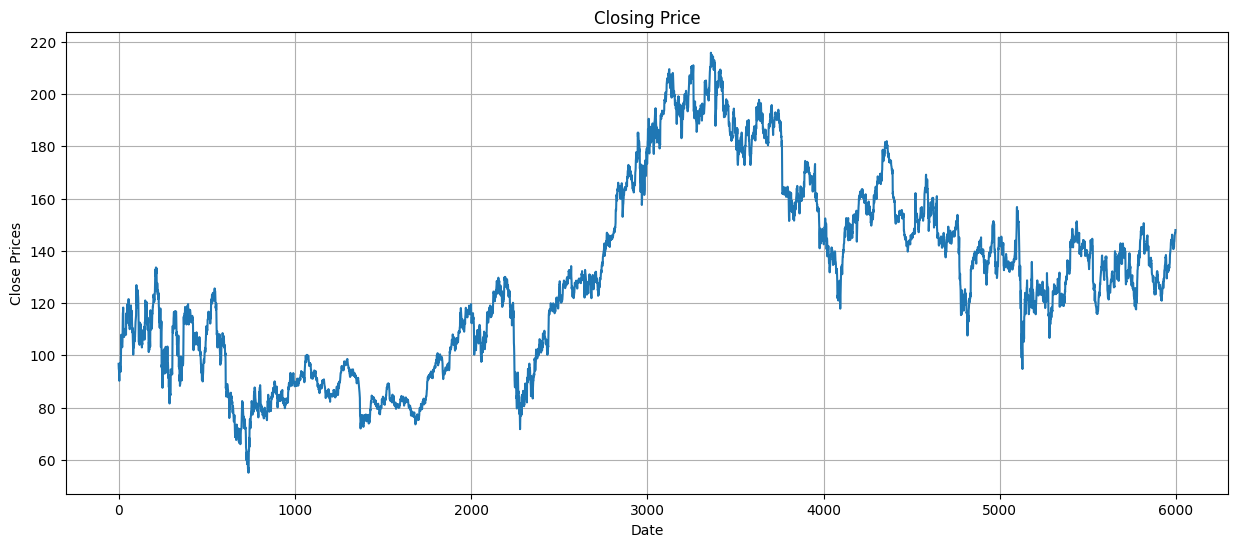

In [56]:
plt.figure(figsize=(15, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_arima['close'])
plt.title('Closing Price')
plt.show()

**Test for stationarity:**

In [57]:
timeseries = df_arima['close']

rolling_mean = timeseries.rolling(12).mean()
rolling_std = timeseries.rolling(12).std()

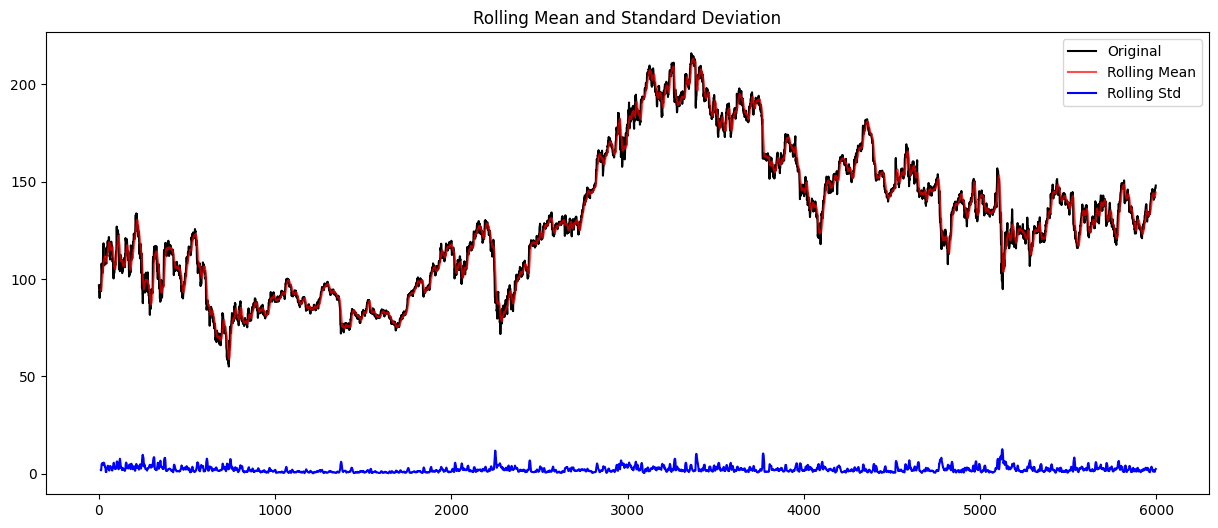

In [58]:
plt.figure(figsize=(15, 6))
plt.plot(timeseries, color='black', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean', alpha=0.7)
plt.plot(rolling_std, color='blue', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()

In [59]:
print("Results of Dickey-Fuller test")

adft = adfuller(timeseries, autolag='AIC')
output = pd.Series(adft[0:4],
                   index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])

for key, values in adft[4].items():
    output[f'Critical Value ({key})'] = values

print(output)

Results of Dickey-Fuller test
Test Statistics                  -1.758082
p-value                           0.401462
No. of lags used                 25.000000
Number of observations used    5972.000000
Critical Value (1%)              -3.431445
Critical Value (5%)              -2.862024
Critical Value (10%)             -2.567028
dtype: float64


**Decompose the time series:**

<Figure size 640x480 with 0 Axes>

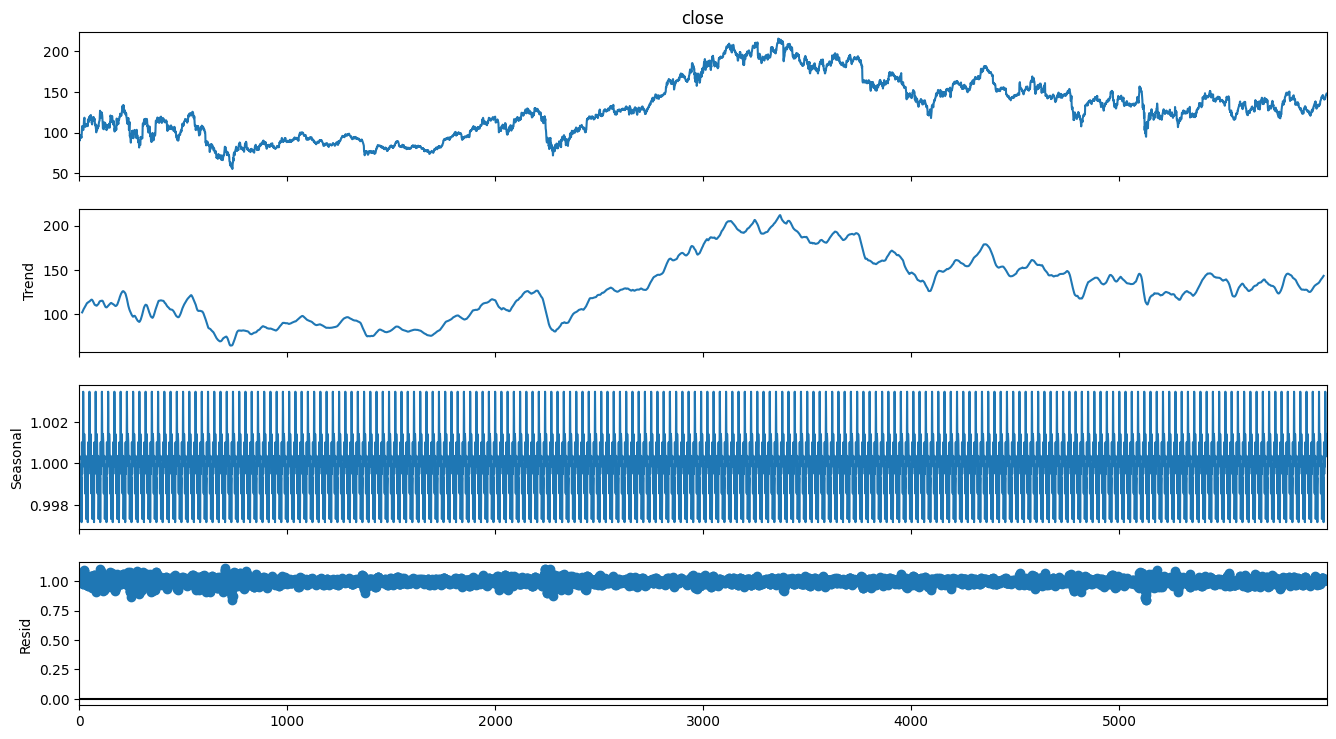

In [60]:
result = seasonal_decompose(timeseries, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 8)

**Eliminate trend:**

In [61]:
moving_avg = timeseries.rolling(12).mean()
std_dev = timeseries.rolling(12).std()

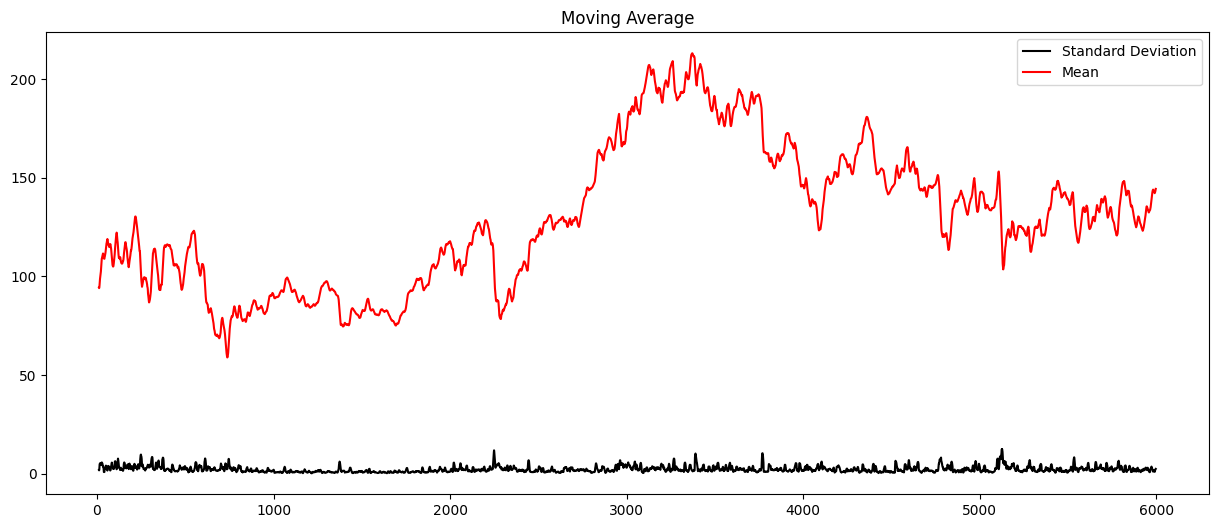

In [62]:
plt.figure(figsize=(15, 6))
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.plot(moving_avg, color="red", label="Mean")
plt.legend()
plt.title('Moving Average')
plt.show()

**AutoARIMA:**

Automatic ARIMA, a part of the broader class of ARIMA models, which are widely used in the field of time series forecasting. AutoARIMA is a valuable tool for time series forecasting because it automates the process of selecting the most suitable ARIMA model, making it accessible to a broader audience of users and ensuring that the chosen model is based on statistical criteria rather than guesswork. It is particularly useful when dealing with large datasets or when users lack extensive expertise in time series analysis.






We'll uses the `auto_arima` function to automatically determine the best ARIMA model for our time series data. Here are the key parameters used in the function:

   - `start_p=0`, `start_q=0`: Starting values for the order of the autoregressive (p) and moving average (q) components.
   - `test='adf'`: The method for determining the order of differencing (ADF test).
   - `max_p=3`, `max_q=3`: Maximum values for the order of p and q.
   - `m=1`: Seasonal frequency (set to 1 for non-seasonal data).
   - `d=None`: The order of differencing (will be determined automatically).
   - `seasonal=False`: Indicates that the data is non-seasonal.
   - `start_P=0`, `D=0`: Starting values for the seasonal order of p and q.
   - `trace=True`: Print diagnostic information during the model fitting process.
   - `error_action='ignore'`: Ignore errors during the model fitting.
   - `suppress_warnings=True`: Suppress warning messages.
   - `stepwise=True`: Use stepwise search to find the best model.

Starting by split data into train and test sets

In [63]:
train_size = int(len(df_arima) * 0.9)
train_data, test_data = df_arima[:train_size], df_arima[train_size:]

In [64]:
model_autoARIMA = auto_arima(train_data['close'],
                             start_p=0, start_q=0,
                             test='adf',
                             max_p=3, max_q=3,
                             m=1,
                             d=None,
                             seasonal=False,
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22775.720, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22772.202, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22772.230, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22773.780, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22774.172, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22774.142, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22776.176, Time=1.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22770.266, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=22772.235, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22772.206, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22770.294, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=22774.240, Time=0.56 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.120 seconds


The `auto_arima` function performs a stepwise search to minimize the **AIC** (Akaike Information Criterion) and outputs several candidate models with their respective AIC values and fit times.

The best model selected by the function is printed at the end, and it is determined to be an **ARIMA(1,1,0) model with no seasonal components**.

### Modeling:

**Get the selected ARIMA order:**

First, we start by extracting the **order** of the ARIMA model that was selected by the **auto_arima** function earlier.

In [65]:
order = model_autoARIMA.order

**Initialize variables for predictions:**

In this block, various variables are initialized for making predictions. we start by extracting the training and test data from the DataFrame, converting them to NumPy arrays, and initializing a `history` list with training data. `model_predictions` is created to store the predicted values, and `N_test_observations` is set to the length of the test data.

In [66]:
training_data = train_data['close'].values
test_data = test_data['close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

**Initialize the ARIMA model outside the loop:**

We initialize an ARIMA model with the historical data (`history`) and the selected ARIMA order. We then fit the ARIMA model to the historical data, creating a `arima_model_fit` object. This step is performed outside the loop to avoid repeatedly reinitializing the model.

In [67]:
arima_model = ARIMA(history, order=order)
arima_model_fit = arima_model.fit()

**Loop for Forecasting:**

This block is the heart of the forecasting process. It iterates through the test data points, one by one, and performs the following steps for each time point:

- Extracts the true test value for the current time point.
- Updates the `history` with the true test value to incorporate it into the modeling.
- Reinitializes and fits the ARIMA model with the updated `history`.
- Uses the fitted model to forecast the next value (*one-step ahead prediction*).
- Appends the forecasted value (`yhat`) to the model_predictions list.

In [68]:
for time_point in range(N_test_observations):
    # Get the true test value
    true_test_value = test_data[time_point]

    # Update the history with the true test value
    history.append(true_test_value)

    # Re-fit the ARIMA model with the updated history
    arima_model = ARIMA(history, order=order)
    arima_model_fit = arima_model.fit()

    # Forecast the next value
    yhat = arima_model_fit.forecast(steps=1)[0]

    # Append the prediction to the list
    model_predictions.append(yhat)

**Plot predicted vs actual prices:**

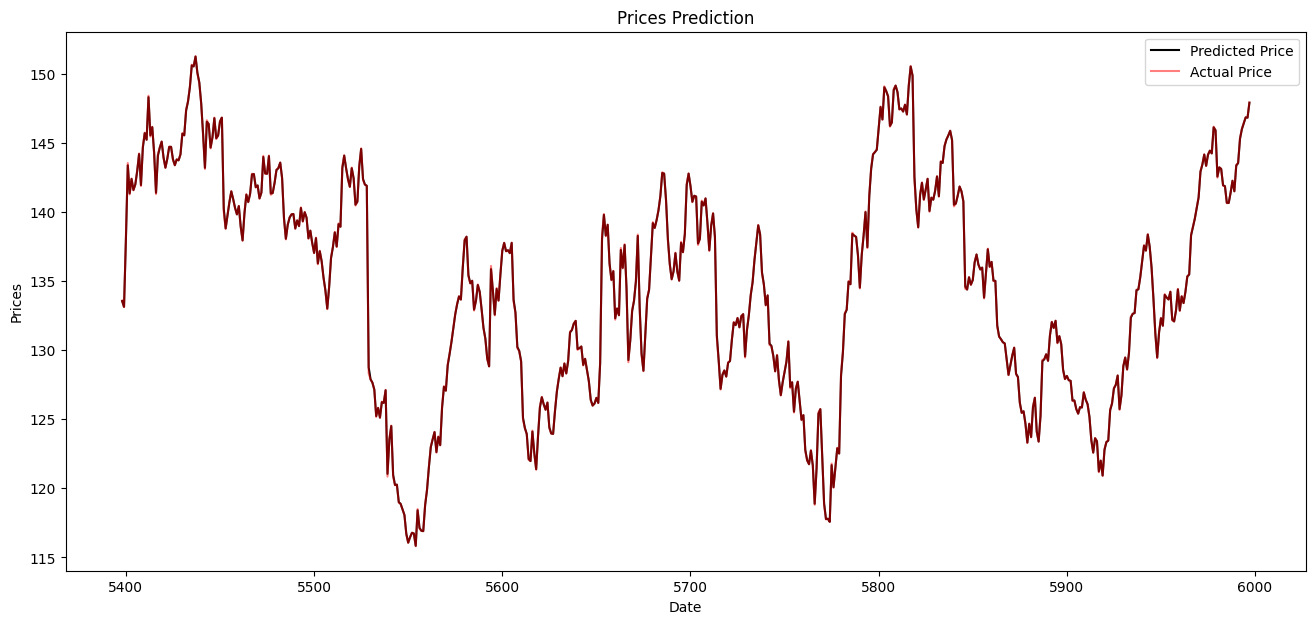

In [69]:
# Plot predicted vs actual prices
test_set_range = df_arima.index[train_size:]
plt.figure(figsize=(16, 7))
plt.plot(test_set_range, model_predictions, color='black', label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price', alpha=0.5)
plt.title('Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

**Report performance metrics:**


In [70]:
mse = mean_squared_error(test_data, model_predictions)
mae = mean_absolute_error(test_data, model_predictions)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(model_predictions - test_data) / np.abs(test_data))
r2 = r2_score(y_test, y_pred)

print('MSE: {:.3f}'.format(mse))
print('MAE: {:.3f}'.format(mae))
print('RMSE: {:.3f}'.format(rmse))
print('MAPE: {:.3f}%'.format(mape * 100))
print("R-squared: {}".format(r2))

MSE: 0.003
MAE: 0.037
RMSE: 0.053
MAPE: 0.027%
R-squared: 0.9997637959865572


## Model Comparison and Selection:

In our quest to choose the best model for our project, we've embarked on a crucial journey in the realm of data analysis and machine learning. The choice of our model holds the power to greatly impact the accuracy and trustworthiness of our predictions. To guide us on this path, we've relied on the Mean Squared Error (`MSE`), a trusted yardstick for measuring prediction quality. As we weigh our options, it's worth noting the MSE values each model has earned:
- Random Forest (`MSE = 0.36`),
- XGBoost (`MSE = 0.29`),
- ARIMA (`MSE = 0.003`).

Amidst these contenders, one model has stood out, shining with an impressively low MSE of 0.003 - **`ARIMA`**. What sets *ARIMA* apart is its real-time modeling capabilities, aligning perfectly with the needs of our project. This means that ARIMA excels in *capturing and forecasting time-dependent patterns*, making it an ideal choice for our dynamic and time-sensitive project requirements. With ARIMA as our chosen model, we're poised to achieve precise and timely predictions, elevating the quality of our project outcomes.

# Data Streaming:

`Confluent Cloud Kafka` empowers our project by providing the tools and infrastructure needed for real-time data ingestion, processing, and integration with machine learning. Its scalability, reliability, and managed service approach simplify the development of real-time machine learning solutions, ensuring our solution can harness the full potential of streaming data for intelligent decision-making

Define necessary functions:

In [71]:
def cleaned_data(url):
    r = requests.get(url)
    data = r.json()

    df = pd.DataFrame.from_dict(data['Time Series (Daily)']).T

    df = df.reindex(index=df.index[::-1])
    df.columns = [col.split('. ')[1] for col in df.columns]
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'}, inplace=True)

    df['date'] = pd.to_datetime(df['date'])
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])

    df = df.drop(["open","high", "low","volume",'date'], axis = 1)
    df = df.reset_index(drop=True)

    return df

In [72]:
def prediction_results(data):
    train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

    training_data = train_data['close'].values
    test_data = test_data['close'].values

    history = [x for x in training_data]
    model_predictions = []
    N_test_observations = len(test_data)

    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()

    for time_point in range(N_test_observations):
        true_test_value = test_data[time_point]

        history.append(true_test_value)

        model = ARIMA(history, order=(1, 1, 0))
        model_fit = model.fit()

        yhat = model_fit.forecast(steps=1)[0]

        model_predictions.append(yhat)

    next_day_prediction = model_fit.forecast(steps=1)[0]

    return next_day_prediction

In [73]:
# Callback function to check delivery status
def delivery_report(err, msg):
    if err is not None:
        print('Message delivery failed: {}'.format(err))
    else:
        print('Message delivered to {} [{}]'.format(msg.topic(), msg.partition()))

Confluent Cloud configuration:

Configuring both producers and consumers in Confluent Cloud is like giving your event-streaming system its own keys to the castle. It's essential because it lets you decide who gets in and who gets out, ensuring your data's safety and following the rules.

1. Producer:

The producer is responsible for sending data to Kafka topics in Confluent Cloud. It generates and publishes data, which can be anything from log entries to user actions, and sends it to specific Kafka topics.

2. Consumer:

The consumer reads and processes data from Kafka topics in Confluent Cloud. It subscribes to specific topics and consumes messages or events in real-time or batch mode. Consumers can perform various data processing tasks, including data transformation, enrichment, and storage.

configuring  them is like fine-tuning your favorite instrument for the best performance. Configuration allows you to set the rules, making sure only the right folks have access, and your data flows smoothly and securely.

In [74]:
producer_conf = {
    "bootstrap.servers": "pkc-921jm.us-east-2.aws.confluent.cloud:9092",
    "sasl.mechanisms": "PLAIN",
    "security.protocol": "SASL_SSL",
    "sasl.username": "EZ2JWRQPD2TDKYQQ",
    "sasl.password": "zMCP7SYUEv+XkX8+fqqro1AbKmCGhsMD3be32OIS7JXslHO6Iyv+b3KBcwYT+VxP",
    "broker.version.fallback": "0.10.0.0",
    "api.version.fallback.ms": 0
}

consumer_conf = {
    "bootstrap.servers": "pkc-921jm.us-east-2.aws.confluent.cloud:9092",
    "sasl.mechanisms": "PLAIN",
    "security.protocol": "SASL_SSL",
    "sasl.username": "EZ2JWRQPD2TDKYQQ",
    "sasl.password": "zMCP7SYUEv+XkX8+fqqro1AbKmCGhsMD3be32OIS7JXslHO6Iyv+b3KBcwYT+VxP",
    "group.id": "spring-boot-avro-consumer-id",
    "auto.offset.reset": "earliest"   # Start consuming from the beginning of the topic
}

# Topic to produce messages to
topic = '3D_topic'

**Produce:**

In [75]:
# Create a Kafka producer instance
producer = Producer(producer_conf)

# Produce a message to the topic
df = cleaned_data(url)
df_json = df.to_json(date_format='iso', orient='split')

producer.produce(topic, df_json.encode('utf-8'), callback=delivery_report)

# Wait for any outstanding messages to be delivered and delivery reports to be received
producer.flush()

print("Message produced successfully.")

Message delivered to 3D_topic [0]
Message produced successfully.


**Consumer:**

In [76]:
# Create a Kafka consumer instance
consumer = Consumer(consumer_conf)

# Subscribe to the topic
consumer.subscribe([topic])

In [77]:
while True:
    message = consumer.poll(1.0)
    if message is None:
        continue

    if message.error():
        print("Error:", message.error())
        continue

    try:
        value = message.value().decode('utf-8')
        print("Received message")

        dfs = pd.read_json(value, orient='split')
        print("\nDataFrame created:\n", dfs)

        predictions = prediction_results(dfs)
        print("\nPredicted Price for the Next Day:", predictions)
        break

    except Exception as e:
        print("Error:", e)

consumer.close()

Received message

DataFrame created:
        close
0      96.75
1      94.81
2      94.37
3      91.56
4      90.25
...      ...
5993  146.02
5994  146.45
5995  146.86
5996  146.83
5997  147.94

[5998 rows x 1 columns]

Predicted Price for the Next Day: 147.91381991595915


# Automation

In our project, we have implemented an extensive and finely-tuned automation framework that serves as the backbone of our development and deployment processes. Automation, in our context, is not just a convenience but a strategic imperative. To achieve this, we chose `Jenkins` as our automation platform, primarily due to its powerful capabilities in orchestrating complex workflows and its strong support for continuous integration and continuous delivery (CI/CD) practices. Our Jenkins setup is designed around a **freestyle job**, meticulously configured to cater to our project's unique needs.This job is scheduled to run our `main.py` script at a specific time every day, ensuring that our processes are executed consistently and efficiently.

![Jenkins Job](../images/jenkins_job_interface.png)

One of our key strategies for maintaining a streamlined and maintainable codebase is splitting the entire project into packages and scripts. This decision offers numerous advantages, such as improved code organization, enhanced readability, and simplified maintenance. Each package encapsulates specific functionalities, ensuring that our project remains modular and extensible. It also promotes team collaboration, as we can work on individual packages independently, reducing conflicts and ensuring smoother development cycles.

Here's the project structure for reference:

```html
3D
├── main.py
├── config
│   ├── data_config.json
│   ├── email_config.json
│   ├── kafka_config.json
├── data
│   ├── __init__.py
│   ├── data.py
│   ├── preprocessing.py
├── images
│   ├── close_values_with_prediction.png
│   ├── email.png
│   ├── jenkuns_job_interface.png
│   ├── job_execution.png
├── kafka
│   ├── consumer.py
│   ├── producer.py
├── mail
│   ├── sendMail.py
│   ├── __init__.py
├── model
│   ├── arima.py
│   ├── __init__.py
├── notebooks
│   ├── Sujet13_3DSF.ipynb
├── other
│   ├── other.txt
├── report
│   ├── report.pdf
│   ├── report.docx
├── resources/
│   ├── 3d_project_log.txt
├── utils
│   ├── logger.py
```

Furthermore, we have integrated a '`sendMail`' function into our automation workflow. This function automates the process of sending an email notification to the end-user, providing them with valuable insights and predictions. When the code execution completes, an email is automatically dispatched, offering the user the predicted value and any other relevant information. This not only keeps our stakeholders well-informed but also enhances the user experience by providing real-time updates on project progress and results.

Our commitment to automation is driven by the desire to achieve operational excellence. By harnessing the power of Jenkins and meticulously splitting our code into packages, we have optimized our development pipeline, reduced manual intervention, and minimized the risk of human error. This approach allows us to focus our efforts on innovation and creative problem-solving, resulting in a more agile, efficient, and reliable project development process.

**Final output:**

- Job Execution:

![job_execution](../images/job_execution.jpeg)

- E-mail received:

![email](../images/email.png)